## Chapter 1:   Introduction

In [1]:
import requests
import numpy as np
import pandas as pd
from astropy import units as u
from astropy import constants as c
import Planet_tools as pt
import matplotlib.pyplot as plt
from copy import copy

In [2]:
# exo_eu = pd.read_csv("http://exoplanet.eu/catalog/csv",
#                  usecols=["# name",'orbital_period','star_radius','star_mass',
#                           'mass','mass_sini','radius','semi_major_axis',])
# #'mag_v','inclination','impact_parameter','eccentricity','omega'
# exo_eu = exo_eu.loc[(exo_eu["orbital_period"]<10000)]


### 1.1 Overview

In [4]:
#read table of confirmed planet downloaded from NASA Exoplanet Archive
df = pd.read_csv("confirmed_planets.csv", skiprows=17 )
print(f"There are {len(df)} confirmed exoplanets")
df.head(5)

There are 4400 confirmed exoplanets


,pl_name,default_flag,discoverymethod,disc_year,pl_orbper,pl_rade,pl_radj,pl_bmasse,pl_bmassj
0,11 Com b,1,Radial Velocity,2007,326.03000,NaN,NaN,6165.6000,19.40
1,11 UMi b,1,Radial Velocity,2009,516.21997,NaN,NaN,4684.8142,14.74
2,14 And b,1,Radial Velocity,2008,185.84000,NaN,NaN,1525.5000,4.80
3,14 Her b,1,Radial Velocity,2002,1773.40002,NaN,NaN,1481.0878,4.66
4,16 Cyg B b,1,Radial Velocity,1996,798.50000,NaN,NaN,565.7374,1.78


In [7]:
# options = ['Radial Velocity', 'Transit', 'Transit Timing Variations']
# df = df.loc[(df["discoverymethod"].isin(options))]
# print(len(df))

In [5]:
print(f'Number of planets detected by transit is {len(df.loc[df["discoverymethod"].isin(["Transit"])])}')
print(f'Number of planets detected by Radial Velocity is {len(df.loc[df["discoverymethod"].isin(["Radial Velocity"])])}')

Number of planets detected by transit is 3335
Number of planets detected by Radial Velocity is 850


######  Fig 1.1: Period-Mass-Radius plot

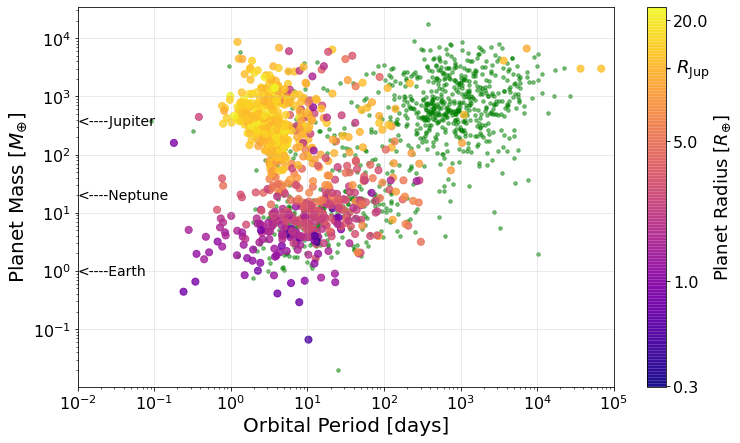

In [6]:
plt.rc('ytick', labelsize=16)
plt.rc('xtick', labelsize=16)
fig = plt.figure(figsize=(12,7))
plt.grid("on", alpha=0.3)
plt.scatter(df["pl_orbper"][np.isnan(df["pl_rade"])], df["pl_bmasse"][np.isnan(df["pl_rade"])],
            s=50,marker=".", c= "g", alpha=0.5,label="Radial Velocity")

plt.scatter(df["pl_orbper"], df["pl_bmasse"],c=np.log10(df["pl_rade"]), cmap="plasma",s =50,
            alpha=0.8, label="Transit")

plt.xscale("log")
plt.yscale("log")
cbar = plt.colorbar(ticks=np.log10([0.3,1,5,20]))
cbar.ax.set_yticklabels(np.round(10**cbar.get_ticks(),1))
cbar.set_label('Planet Radius [$R_{\oplus}$]', fontsize=18)

plt.xlim([0.01, 10e4]);
plt.xlabel("Orbital Period [days]", fontsize=20)
plt.ylabel("Planet Mass [$M_{\oplus}$]", fontsize=20);
plt.text(0.01,0.85,"<----Earth",fontsize=14)
plt.text(0.01,17.15,"<----Neptune",fontsize=14)
plt.text(0.01,317.8,"<----Jupiter",fontsize=14)
plt.text(4.5e5,2500,"- $R_{\mathrm{Jup}}$",fontsize=18);

In [10]:
# fig.savefig("period-mass-radius.pdf", bbox_inches="tight")

#### Plot Period against radius (not shown in thesis)

/home/tunde/miniconda3/envs/python3_env/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


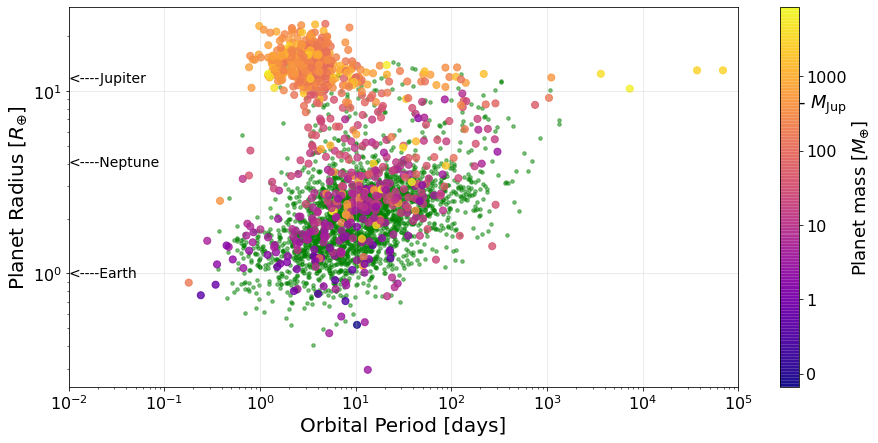

In [14]:
plt.rc('ytick', labelsize=16)
plt.rc('xtick', labelsize=16)
fig = plt.figure(figsize=(15,7))
plt.grid("on", alpha=0.3)
plt.scatter(df["pl_orbper"][np.isnan(df["pl_bmasse"])], df["pl_rade"][np.isnan(df["pl_bmasse"])],
            s=50,marker=".", c= "g", alpha=0.5,label="Radial Velocity")

plt.scatter(df["pl_orbper"], df["pl_rade"],c=np.log10(df["pl_bmasse"]), cmap="plasma",s =50,
            alpha=0.8, label="Transit")

plt.xscale("log")
plt.yscale("log")
cbar = plt.colorbar()#ticks=np.log10([0.3,1,5,20])
cbar.ax.set_yticklabels([np.int(v) for v in np.round(10**cbar.get_ticks(),1)])
cbar.set_label('Planet mass [$M_{\oplus}$]', fontsize=18)

plt.xlim([0.01, 10e4]);
plt.xlabel("Orbital Period [days]", fontsize=20)
plt.ylabel("Planet Radius [$R_{\oplus}$]", fontsize=20);
plt.text(0.01,0.95,"<----Earth",fontsize=14)
plt.text(0.01,3.86,"<----Neptune",fontsize=14)
plt.text(0.01,11.2,"<----Jupiter",fontsize=14)
plt.text(4.2e5,8,"- $M_{\mathrm{Jup}}$",fontsize=18);

######  Fig 1.2: Cumulative  number  of  exoplanetdetections  by  year  and  method

<img src="exo_dischist_cumulative.png"  width="600" height="600">

### 1.2  Detection Methods

#### 1.2.1 Radial Velocity (RV) Method

######  Fig 1.3: left: Schematic of the radial velocity method

<img src="rv_method.jpg"  width="500" height="500">

In [11]:
import radvel
print(radvel.__version__)

1.4.5


In [12]:
#simulate jupiter mass planet with 1 year orbit (k=28.4m/s)
#circular orbit
params = radvel.Parameters(1, basis='per tc e w k')
params['k1'] = radvel.Parameter(value=28.4)
params['per1'] = radvel.Parameter(value=1)
params['e1'] = radvel.Parameter(value=0)
params['w1'] = radvel.Parameter(value=+0)
params['tc1'] = radvel.Parameter(value=0.)
rv_mod = radvel.RVModel(params)

In [13]:
#eccentric orbit
params2 = copy(params)
e=0.2; w = 120
params2['e1'] = radvel.Parameter(value=e)
params2['w1'] = radvel.Parameter(value=w)
rv_mod2 = radvel.RVModel(params2)

######  Fig 1.3: right: RV  signal  of  a Jupiter-mass planet with a Period of 1 yr

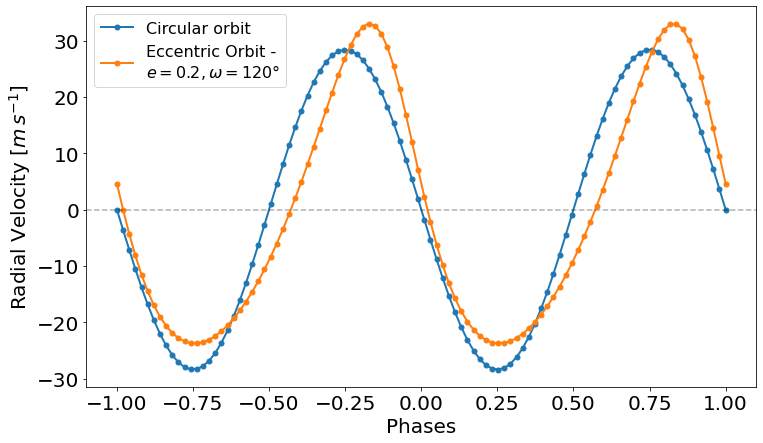

In [14]:
plt.rc('ytick', labelsize=20)
plt.rc('xtick', labelsize=20)

phases = np.linspace(-1,1,100)

fig = plt.figure(figsize=(12,7))
plt.plot(phases,rv_mod(phases),"o-",lw=2,label='Circular orbit')
plt.plot(phases,rv_mod2(phases),"o-",lw=2,label='Eccentric Orbit -\n$e=0.2, \omega = 120\degree$')
plt.axhline(0, ls="dashed", c="k", alpha=0.3)
plt.legend(fontsize=16)
plt.xlabel("Phases",fontsize=20)
plt.ylabel("Radial Velocity [$m\,s^{-1}$]",fontsize=20);

In [123]:
# fig.savefig("Radialvelocity_signal.pdf", bbox_inches="tight")

#### 1.2.2 Transit Method

###### Fig 1.4: Light-curve   of   thefirst  detected  transiting  exoplanet HD 209458 b  (Charbonneau  et  al.,2000)

<img src="hd209458transit.jpg"  width="500" height="500">